In [15]:
# Classical
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim

# Misc
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 15, 7

This notebook is inspired by Sebastian Ruder's awesome work... from http://ruder.io/optimizing-gradient-descent/. Only think we don't implement in this notebook is gradient calculations, which is conviniently provided by PyTorch.

### References

* http://www.fast.ai/, Fast.ai ML, Fast.ai DL
* http://ruder.io/optimizing-gradient-descent/
* http://cs231n.github.io/neural-networks-3/#sgd

In [2]:
data = pd.read_csv('./data/MNIST/train.csv')
data = np.array(data)

In [99]:
class MNIST(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, index):
        X = data[index][1:]
        y = data[index][0]
        return torch.from_numpy(X).float()/256, torch.LongTensor(np.array([y]))
    
    def __len__(self):
        return len(self.data)

In [100]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        for lin in self.linears:
            lin_x = lin(x)
            x = F.relu(lin_x)
        return F.log_softmax(lin_x)

In [101]:
# Create dataset
mnist = MNIST(data)
data_dl = DataLoader(mnist, batch_size= 256, shuffle=True, num_workers=0)

### Training With DIfferent Optimizers

In [102]:
epochs = 3 # set epohcs
criterion = nn.NLLLoss() # define loss function 

### Vanilla Mini Batch -  SGD

In [ ]:
### Algorithm
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        grads = compute.grads(batch,weight, loss_func)
        params -= lr*grads

In [106]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-2

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for w, b in wbs:
            w.data -= lr*w.grad.data
            b.data -= lr*b.grad.data
            # zero the gradients
            w.grad.data.zero_()
            
            b.grad.data.zero_()
        

epoch 0
epoch 1
epoch 2


In [107]:
sgd_losses_ = [(l.data.numpy()[0]) for l in losses]
sgd_log_losses_ = [np.log(l) for l in sgd_losses_]

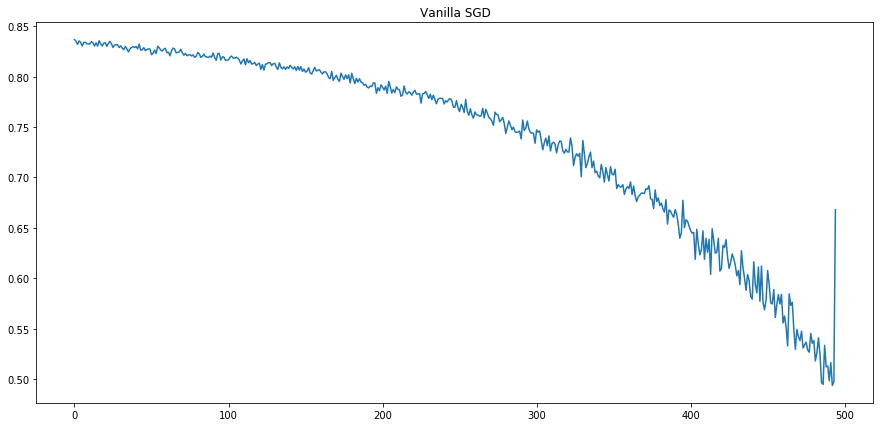

In [108]:
plt.plot(sgd_log_losses_)
title = plt.title("Vanilla SGD")

### PyTorch Built-in

Here you can test various optimizers by simply changing optim.(__optimizer__ ). It's also nice to see each optimizer has it's own nature and hence kind of seem to need a unique lr. That's actually shows the power of and nedd for the lr_find().

In [183]:
### Training Pytorch
### init architecture
snet = SimpleNet([784, 100, 100, 10])
optimizer = optim.Adam(lr = lr, params=snet.parameters())
losses = []
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        optimizer.step()
        optimizer.zero_grad()

epoch 0
epoch 1
epoch 2


In [184]:
pyadam_losses_ = [(l.data.numpy()[0]) for l in losses]
pyadam_log_losses_ = [np.log(l) for l in pyadam_losses_]

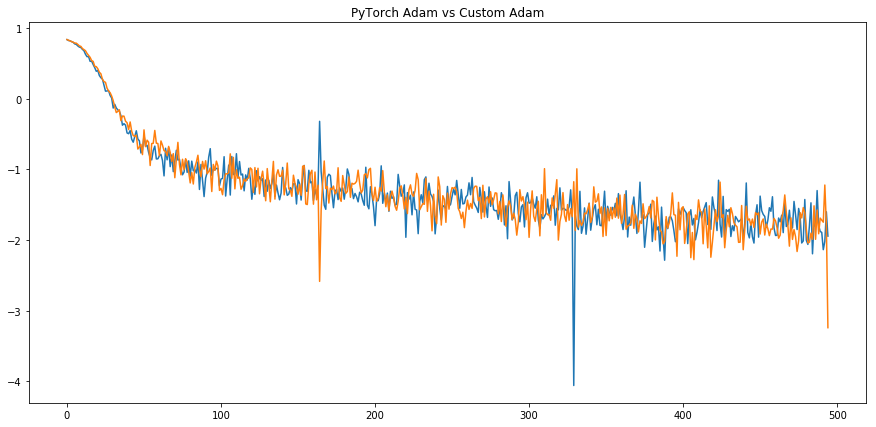

In [186]:
plt.plot(pyadam_log_losses_)
plt.plot(adam_log_losses_)
title = plt.title("PyTorch Adam vs Custom Adam")

### SGD with momentum

We'd like to pass saddle points with the use of momentum, if not it's faster...

In [ ]:
### Algorihtm
v_new = 0 #init update
rho = 0.9 #set rho
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        v_new = rho*v_prev + lr*compute.grads(batch, weight, loss_func)
        params -= v_new
        v_prev = v_new 

In [116]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
rho = 0.9
weight_v_prev = [0 for i in range(len(wbs))] # initialize momentum term
bias_v_prev = [0 for i in range(len(wbs))] # initialize momentum term

epochs = 3

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            weight_v_new = rho*weight_v_prev[i] + lr*w.grad.data
            bias_v_new = rho*bias_v_prev[i] + lr*b.grad.data
            
            weight_v_prev[i] = weight_v_new
            bias_v_prev[i] = bias_v_new
            
            w.data -= weight_v_new
            b.data -= bias_v_new
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()
        

epoch 0
epoch 1
epoch 2


In [117]:
sgdmom_losses_ = [(l.data.numpy()[0]) for l in losses]
sgdmom_log_losses_ = [np.log(l) for l in sgdmom_losses_]

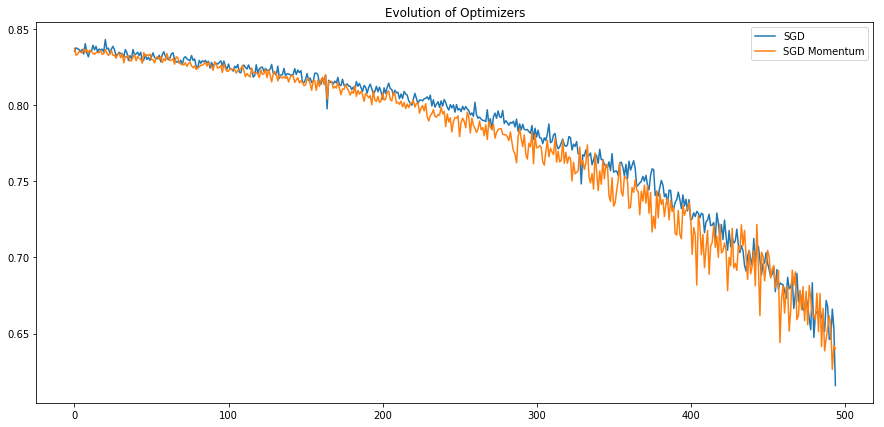

In [138]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum'))

### Nesterov 

**Need to check this later, not sure if giving correct results as we expect to see this to be faster in terms of convergence**

We'd like to have a smarter ball, a ball that has a notion of where it is going so that it knows to slow down before the hill slopes up again. While computing grads wrt to weight - rho*v_prev, we have a sense of what will be the next position of our ball will, so we can leverage this and make a better update.

In [ ]:
###Algorithm
v_prev = 0 #init update
rho = 0.9 #set rho
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        v_new = rho*v_prev + lr*compute.grads(batch, params - rho*v_prev, loss_func)
        params -= v_new
        v_prev = v_new

In [123]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
rho = 0.9
weight_v_prev = [0 for i in range(len(wbs))] # initialize momentum term
bias_v_prev = [0 for i in range(len(wbs))] # initialize momentum term

epochs = 3

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for n, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            ### WEIGHT UPDATE
            # take a step in future as if we are updating
            w_original = w.data
            w.data -= rho*weight_v_prev[i]
            # caluclate loss and gradients, to see how would it be 
            future_outputs = snet(inputs)
            future_loss = criterion(outputs, labels.squeeze(-1))
            future_loss.backward(retain_graph=True)
            future_grad = w.grad.data
                     
            weight_v_new = rho*weight_v_prev[i] + lr*future_grad #future grad
            weight_v_prev[i] = weight_v_new
            w.data = w_original #get the original weight data
            w.data -= weight_v_new #update
            
            # zero all gradients
            snet.zero_grad()
            
            
            ### BIAS UPDATE
            # take a step in future as if we are updating
            b_original = b.data
            b.data -= rho*bias_v_prev[i]
            
            # calculate loss and gradient, to see how would it be
            future_outputs = snet(inputs)
            future_loss = criterion(outputs, labels.squeeze(-1))
            future_loss.backward(retain_graph=True)
            future_grad = b.grad.data
            
            bias_v_new = rho*bias_v_prev[i] + lr*future_grad
            bias_v_prev[i] = bias_v_new
            b.data = b_original
            b.data -= bias_v_new
            
            # zero all gradients
            snet.zero_grad()

epoch 0
epoch 1
epoch 2


In [124]:
nesterov_losses_ = [(l.data.numpy()[0]) for l in losses]
nesterov_log_losses_ = [np.log(l) for l in nesterov_losses_]

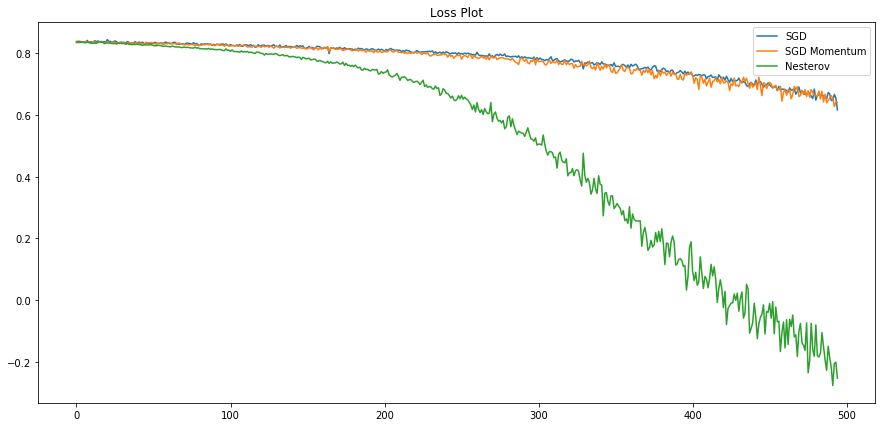

In [125]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
title = plt.title("Loss Plot")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov'))

### Adagrad

It adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters. In its update rule, Adagrad modifies the general learning rate ηη at each time step tt for every parameter θiθi based on the past gradients that have been computed for θiθi:

One of Adagrad's main benefits is that it eliminates the need to manually tune the learning rate. Most implementations use a default value of 0.01 and leave it at that.

Adagrad's main weakness is its accumulation of the squared gradients in the denominator: Since every added term is positive, the accumulated sum keeps growing during training. This in turn causes the learning rate to shrink and eventually become infinitesimally small, at which point the algorithm is no longer able to acquire additional knowledge. The following algorithms aim to resolve this flaw.

In [ ]:
###Algorithm
grad_squared = 0
noise = 1e-8
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        grads = compute.grads(batch, weight, loss_func)
        params -= lr*(grads / (np.sqrt(grads_squared) + noise))
        grads_sqaured += grads*grads

In [129]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
grads_squared = [[torch.zeros(wb[0].size()), torch.zeros(wb[1].size())] for wb in wbs]
noise = 1e-8

epochs = 3

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w.data -= lr*w.grad.data / torch.sqrt(grads_squared[i][0] + noise)
            b.data -= lr*b.grad.data / torch.sqrt(grads_squared[i][1] + noise)
            
            grads_squared[i][0] += w.grad.data*w.grad.data
            grads_squared[i][1] += b.grad.data*b.grad.data
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [130]:
adagrad_losses_ = [(l.data.numpy()[0]) for l in losses]
adagrad_log_losses_ = [np.log(l) for l in adagrad_losses_]

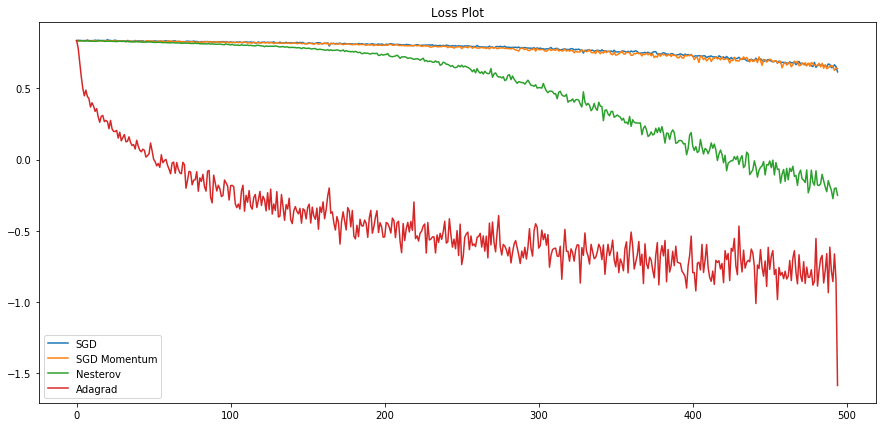

In [132]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
title = plt.title("Loss Plot")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad'))

### Adadelta/RMSProp

Adadelta restricts the window of accumulated past gradients to some fixed size ww.

Instead of inefficiently storing ww previous squared gradients, the sum of gradients is recursively defined as a decaying average of all past squared gradients. The running average E[g2]tE[g2]t at time step tt then depends (as a fraction γγ similarly to the Momentum term) only on the previous average and the current gradient:

RMSprop and Adadelta have both been developed independently around the same time stemming from the need to resolve Adagrad's radically diminishing learning rates. RMSprop in fact is identical to the first update vector of Adadelta that we derived above:

In [ ]:
###Algorithm
grad_squared = 0
rho = 0.9 # param for exponential smoothing on grad squares
for i in range(epochs):
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        grads = compute.grads(batch, weight, loss_func)
        grads_sqaured = rho*(grad_squared) + (1 - rho)*(grad*grad)
        params -= lr*(grads / (np.sqrt(grads_squared) + noise))

In [133]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

###params
lr = 1e-3
grads_squared = [[torch.zeros(wb[0].size()), torch.zeros(wb[1].size())] for wb in wbs]
noise = 1e-8
rho = 0.9
epochs = 3

### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights 
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            w.data -= lr*w.grad.data / torch.sqrt(grads_squared[i][0] + noise)
            b.data -= lr*b.grad.data / torch.sqrt(grads_squared[i][1] + noise)
            
            grads_squared[i][0] = rho*grads_squared[i][0] + (1-rho)*w.grad.data*w.grad.data
            grads_squared[i][1] = rho*grads_squared[i][1] + (1-rho)*b.grad.data*b.grad.data
            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [134]:
rmsprop_losses_ = [(l.data.numpy()[0]) for l in losses]
rmsprop_log_losses_ = [np.log(l) for l in rmsprop_losses_]

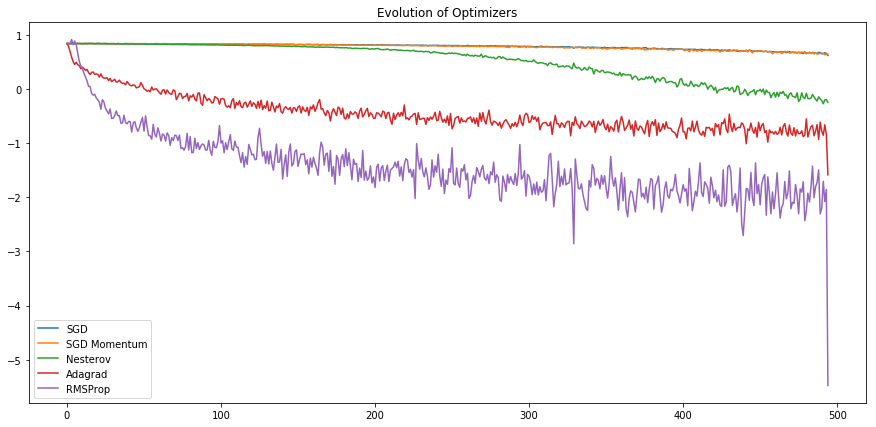

In [136]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp'))

### Adam

In addition to storing an exponentially decaying average of past squared gradients vtvt like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients mtmt, similar to momentum.As mtmt and vtvt are initialized as vectors of 0's, the authors of Adam observe that they are biased towards zero, especially during the initial time steps, and especially when the decay rates are small (i.e. β1β1 and β2β2 are close to 1).

They counteract these biases by computing bias-corrected first and second moment estimates:

In [ ]:
###Algorithm
m = 0
v = 0
beta1 = 0.999
beta2 = 1e-8
t = 0

for i in range(epochs):
    t += 1
    shuffled = np.random.shuffle(data)
    for batch in get.batch(shuffled, bs):
        grads = compute.grads(batch, weight - rho*v_prev, loss_func)
        m = beta1*m + (1 - beta1)*grads
        v = beta2*v + (1 - beta2)*grads*grads
        m_hat = m / (1 - beta1**t) # bias correction for first moment
        v_hat = v / (1 - beta1**t) # bias correction for second moment
        params -= lr*m_hat/(np.sqrt(v_hat) + noise)

In [168]:
### init architecture
snet = SimpleNet([784, 100, 100, 10])

### get weight, bias objects
wbs = [(lin.weight, lin.bias) for lin in snet.linears]

### keep track of training loss
losses = []

### params
lr = 1e-3

### [((m, v), (m, v))] weight and bias m v prevs
m_v_prevs = [[[0, 0], [0, 0]] for i in range(len(wbs))]

noise = 1e-8
beta1 = 0.9
beta2 = 0.999

epochs = 3

t = 0
### Training 
for epoch in range(epochs):
    print(f'epoch {epoch}')
    for i, batch in enumerate(data_dl):
        
        # keep track of time
        t += 1
        
        inputs, labels = batch
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = snet(inputs)
        
        # compute loss and gradients
        loss = criterion(outputs, labels.squeeze(-1))
        losses.append(loss)
        loss.backward()
        
        # update weights
        for i, wb in enumerate(wbs):
            w = wb[0]
            b = wb[1]
            
            # update weight component
            w_m_v_t_prev = m_v_prevs[i][0]
            w_m_t_prev = w_m_v_t_prev[0]
            w_v_t_prev = w_m_v_t_prev[1]
            
            
            w_m_t_new = beta1*w_m_t_prev + (1 - beta1)*w.grad.data
            w_v_t_new = beta2*w_v_t_prev + (1 - beta2)*(w.grad.data*w.grad.data)
            
            w_m_t_new_hat = w_m_t_new / (1 - beta1**t)
            w_v_t_new_hat = w_v_t_new / (1 - beta2**t)
            
            m_v_prevs[i][0][0] = w_m_t_new
            m_v_prevs[i][0][1] = w_v_t_new
            
            w.data -= lr*w_m_t_new_hat / (torch.sqrt(w_v_t_new_hat) + noise)
            
            # update bias component
            b_m_v_t_prev = m_v_prevs[i][1]
            b_m_t_prev = b_m_v_t_prev[0]
            b_v_t_prev = b_m_v_t_prev[1]
            
            
            b_m_t_new = beta1*b_m_t_prev + (1 - beta1)*b.grad.data
            b_v_t_new = beta2*b_v_t_prev + (1 - beta2)*(b.grad.data*b.grad.data)
            
            b_m_t_new_hat = b_m_t_new / (1 - beta1**t)
            b_v_t_new_hat = b_v_t_new / (1 - beta2**t)
            
            m_v_prevs[i][1][0] = b_m_t_new
            m_v_prevs[i][1][1] = b_v_t_new
            
            b.data -= lr*b_m_t_new_hat / (torch.sqrt(b_v_t_new_hat) + noise)

            
            # zero the gradients
            w.grad.data.zero_()
            b.grad.data.zero_()

epoch 0
epoch 1
epoch 2


In [169]:
adam_losses_ = [(l.data.numpy()[0]) for l in losses]
adam_log_losses_ = [np.log(l) for l in adam_losses_]

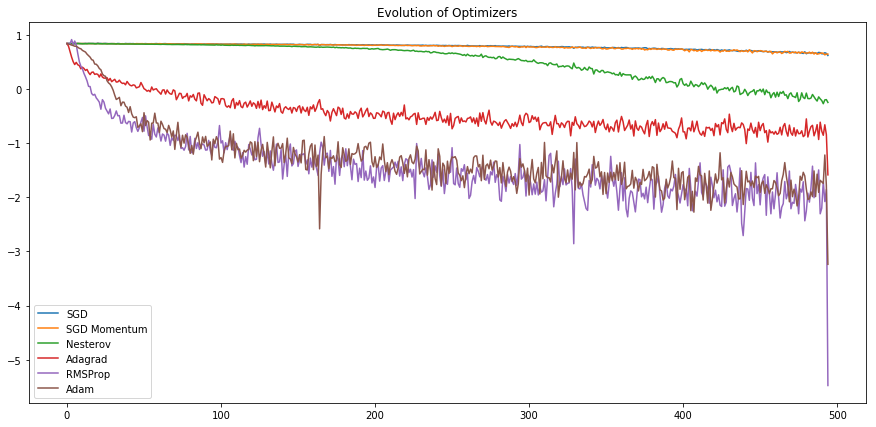

In [170]:
plt.plot(sgd_log_losses_)
plt.plot(sgdmom_log_losses_)
plt.plot(nesterov_log_losses_)
plt.plot(adagrad_log_losses_)
plt.plot(rmsprop_log_losses_)
plt.plot(adam_log_losses_)
title = plt.title("Evolution of Optimizers")
plt.legend(('SGD', 'SGD Momentum', 'Nesterov', 'Adagrad', 'RMSProp', 'Adam'))

In [188]:
### TODO: ADAMAX NADAM